## Experiments 2 ## ML-EdgeIIoT-dataset

In [1]:
import networkx as nx
import torch
import pandas as pd
from torch_geometric.utils import from_networkx
from torch_geometric.data import Data
from sklearn.preprocessing import LabelEncoder, StandardScaler
import category_encoders as ce
from sklearn.model_selection import train_test_split
import socket
import struct
import random
import torch.optim as optim
from torch_geometric.data import DataLoader
import torch.nn.functional as F  # Add this import
from torch_geometric.nn import GCNConv




In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [3]:
data = pd.read_csv('ML-EdgeIIoT-dataset.csv')
(data.head(3))

/tmp/ipykernel_9978/3138900983.py:1: DtypeWarning: Columns (3,6,11,13,14,15,16,17,31,32,34,39,45,51,54,55) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv('ML-EdgeIIoT-dataset.csv')


,frame.time,ip_src_host,ip_dst_host,arp.dst.proto_ipv4,arp.opcode,arp.hw.size,arp.src.proto_ipv4,icmp.checksum,icmp.seq_le,icmp.transmit_timestamp,...,mqtt.proto_len,mqtt.protoname,mqtt.topic,mqtt.topic_len,mqtt.ver,mbtcp.len,mbtcp.trans_id,mbtcp.unit_id,Attack_label,Attack_type
0,6,192.168.0.152,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,MITM
1,6,192.168.0.101,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,MITM
2,6,192.168.0.152,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,MITM


In [4]:
data.columns

Index(['frame.time', 'ip_src_host', 'ip_dst_host', 'arp.dst.proto_ipv4',
       'arp.opcode', 'arp.hw.size', 'arp.src.proto_ipv4', 'icmp.checksum',
       'icmp.seq_le', 'icmp.transmit_timestamp', 'icmp.unused',
       'http.file_data', 'http.content_length', 'http.request.uri.query',
       'http.request.method', 'http.referer', 'http.request.full_uri',
       'http.request.version', 'http.response', 'http.tls_port', 'tcp.ack',
       'tcp.ack_raw', 'tcp.checksum', 'tcp.connection.fin',
       'tcp.connection.rst', 'tcp.connection.syn', 'tcp.connection.synack',
       'tcp.dstport', 'tcp.flags', 'tcp.flags.ack', 'tcp.len', 'tcp.options',
       'tcp.payload', 'tcp.seq', 'tcp.srcport', 'udp.port', 'udp.stream',
       'udp.time_delta', 'dns.qry.name', 'dns.qry.name.len', 'dns.qry.qu',
       'dns.qry.type', 'dns.retransmission', 'dns.retransmit_request',
       'dns.retransmit_request_in', 'mqtt.conack.flags',
       'mqtt.conflag.cleansess', 'mqtt.conflags', 'mqtt.hdrflags', 'mqtt.len

In [5]:
#data = data.groupby(by='Attack_type').sample(frac=0.2, random_state=13)

In [6]:
# Separate the classes you want to keep
keep_classes = ['Fingerprinting', 'MITM']
keep_data = data[data['Attack_type'].isin(keep_classes)]

# Sample 20% from the rest
sampled_data = data[~data['Attack_type'].isin(keep_classes)].groupby('Attack_type').sample(frac=0.2, random_state=13)

# Combine the full keep_data with the sampled data
final_data = pd.concat([keep_data, sampled_data], ignore_index=True)
data = final_data

In [6]:
from sklearn.utils import shuffle
drop_columns = ["frame.time",  "arp.src.proto_ipv4","arp.dst.proto_ipv4", 

         "http.file_data","http.request.full_uri","icmp.transmit_timestamp",

         "http.request.uri.query", "tcp.options","tcp.payload","tcp.srcport",

         "tcp.dstport", "udp.port", "mqtt.msg","Attack_label"]

data.drop(drop_columns, axis=1, inplace=True)

data.dropna(axis=0, how='any', inplace=True)

data.drop_duplicates(subset=None, keep="first", inplace=True)

data = shuffle(data)

data.isna().sum()

print(data['Attack_type'].value_counts())


Attack_type
Normal                   24128
DDoS_UDP                 14498
DDoS_ICMP                14090
DDoS_HTTP                10495
SQL_injection            10284
DDoS_TCP                 10247
Uploading                10222
Vulnerability_scanner    10063
Password                  9973
Backdoor                  9868
Ransomware                9692
XSS                       9558
Port_Scanning             8928
Fingerprinting             857
MITM                       364
Name: count, dtype: int64


In [7]:
# Separate the classes you want to keep
keep_classes = ['Fingerprinting', 'MITM']
keep_data = data[data['Attack_type'].isin(keep_classes)]

# Sample 20% from the rest
sampled_data = data[~data['Attack_type'].isin(keep_classes)].groupby('Attack_type').sample(frac=0.2, random_state=13)

# Combine the full keep_data with the sampled data
final_data = pd.concat([keep_data, sampled_data], ignore_index=True)
data = final_data

In [8]:

# Print number of samples per attack type
print(data['Attack_type'].value_counts())


Attack_type
Normal                   4826
DDoS_UDP                 2900
DDoS_ICMP                2818
DDoS_HTTP                2099
SQL_injection            2057
DDoS_TCP                 2049
Uploading                2044
Vulnerability_scanner    2013
Password                 1995
Backdoor                 1974
Ransomware               1938
XSS                      1912
Port_Scanning            1786
Fingerprinting            857
MITM                      364
Name: count, dtype: int64


In [9]:
from sklearn import preprocessing

label_encoder = preprocessing.LabelEncoder()
data["Attack_type"] = label_encoder.fit_transform(data["Attack_type"].astype(str))
data['http.request.method']= label_encoder.fit_transform(data['http.request.method'].astype(str))
#http.referer#http.request.version
data['http.referer']= label_encoder.fit_transform(data['http.referer'].astype(str))
data['http.request.version']= label_encoder.fit_transform(data['http.request.version'].astype(str))
#dns.qry.name.len
data['dns.qry.name.len']= label_encoder.fit_transform(data['dns.qry.name.len'].astype(str))
data['mqtt.conack.flags']= label_encoder.fit_transform(data['mqtt.conack.flags'].astype(str))
data['mqtt.protoname']= label_encoder.fit_transform(data['mqtt.protoname'].astype(str))
data['mqtt.topic']= label_encoder.fit_transform(data['mqtt.topic'].astype(str))


In [10]:
from imblearn.under_sampling import RandomUnderSampler
from collections import Counter

Y = data['Attack_type']
#data.drop('Attack_type', axis=1, inplace = True)

 

In [11]:
# Combine IP and port to form unique identifiers
data['ip_src_host'] = data.ip_src_host.apply(lambda x: socket.inet_ntoa(struct.pack('>I', random.randint(0xac100001, 0xac1f0001))))
data['ip_dst_host'] = data.ip_dst_host.apply(str)

In [12]:
data.head(3)

,ip_src_host,ip_dst_host,arp.opcode,arp.hw.size,icmp.checksum,icmp.seq_le,icmp.unused,http.content_length,http.request.method,http.referer,...,mqtt.msgtype,mqtt.proto_len,mqtt.protoname,mqtt.topic,mqtt.topic_len,mqtt.ver,mbtcp.len,mbtcp.trans_id,mbtcp.unit_id,Attack_type
0,172.30.132.82,192.168.0.128,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,5
1,172.17.57.33,192.168.0.128,0,0,10870,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,5
2,172.19.109.240,192.168.0.170,0,0,26038,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,5


In [13]:

# Scale numerical features
scaler = StandardScaler()
cols_to_norm = list(set(data.columns) - set(['ip_src_host', 'ip_dst_host', 'Attack_type']))
data[cols_to_norm] = scaler.fit_transform(data[cols_to_norm])

# Add 'h' column containing lists of feature values
data['h'] = data[cols_to_norm].values.tolist()

# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(data, data['Attack_type'], test_size=0.2, random_state=123, stratify=data['Attack_type'])


In [14]:
data

,ip_src_host,ip_dst_host,arp.opcode,arp.hw.size,icmp.checksum,icmp.seq_le,icmp.unused,http.content_length,http.request.method,http.referer,...,mqtt.proto_len,mqtt.protoname,mqtt.topic,mqtt.topic_len,mqtt.ver,mbtcp.len,mbtcp.trans_id,mbtcp.unit_id,Attack_type,h
0,172.30.132.82,192.168.0.128,-0.013254,-0.013774,-0.295580,-0.284812,0.0,-0.035146,-0.203074,-0.029057,...,-0.087069,-0.087069,-0.088168,-0.088168,-0.087069,0.0,0.0,0.0,5,"[-0.08816842670027972, -0.17681991451753004, -..."
1,172.17.57.33,192.168.0.128,-0.013254,-0.013774,0.616652,-0.284812,0.0,-0.035146,-0.203074,-0.029057,...,-0.087069,-0.087069,-0.088168,-0.088168,-0.087069,0.0,0.0,0.0,5,"[-0.08816842670027972, -0.17681991451753004, -..."
2,172.19.109.240,192.168.0.170,-0.013254,-0.013774,1.889581,-0.284812,0.0,-0.035146,-0.203074,-0.029057,...,-0.087069,-0.087069,-0.088168,-0.088168,-0.087069,0.0,0.0,0.0,5,"[-0.08816842670027972, -0.17681991451753004, -..."
3,172.22.41.170,0,-0.013254,-0.013774,-0.295580,-0.284812,0.0,-0.035146,-0.203074,-0.029057,...,-0.087069,-0.087069,-0.088168,-0.088168,-0.087069,0.0,0.0,0.0,6,"[-0.08816842670027972, -0.17681991451753004, -..."
4,172.16.2.162,192.168.0.170,-0.013254,-0.013774,-0.293566,-0.262426,0.0,-0.035146,-0.203074,-0.029057,...,-0.087069,-0.087069,-0.088168,-0.088168,-0.087069,0.0,0.0,0.0,5,"[-0.08816842670027972, -0.17681991451753004, -..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31627,172.25.2.94,192.168.0.128,-0.013254,-0.013774,-0.295580,-0.284812,0.0,-0.035146,-0.203074,-0.029057,...,-0.087069,-0.087069,-0.088168,-0.088168,-0.087069,0.0,0.0,0.0,14,"[-0.08816842670027972, -0.17681991451753004, 4..."
31628,172.26.185.116,192.168.0.128,-0.013254,-0.013774,-0.295580,-0.284812,0.0,-0.035146,-0.203074,-0.029057,...,-0.087069,-0.087069,-0.088168,-0.088168,-0.087069,0.0,0.0,0.0,14,"[-0.08816842670027972, -0.17681991451753004, -..."
31629,172.27.74.55,192.168.0.128,-0.013254,-0.013774,-0.295580,-0.284812,0.0,-0.035146,-0.203074,-0.029057,...,-0.087069,-0.087069,-0.088168,-0.088168,-0.087069,0.0,0.0,0.0,14,"[-0.08816842670027972, -0.17681991451753004, -..."
31630,172.27.83.147,192.168.0.128,-0.013254,-0.013774,-0.295580,-0.284812,0.0,-0.035146,-0.203074,-0.029057,...,-0.087069,-0.087069,-0.088168,-0.088168,-0.087069,0.0,0.0,0.0,14,"[-0.08816842670027972, -0.17681991451753004, 4..."


In [16]:
train_class_counts = X_train['Attack_type'].value_counts()
print("Class distribution in X_train:")
print(train_class_counts)
test_class_counts = X_test['Attack_type'].value_counts()
print("Class distribution in X_test:")
print(test_class_counts)

Class distribution in X_train:
Attack_type
7     774
5     686
4     464
2     451
1     338
11    330
3     328
12    328
13    322
8     319
0     316
10    310
14    308
6     291
9     284
Name: count, dtype: int64
Class distribution in X_test:
Attack_type
7     194
5     171
4     116
2     113
1      84
11     82
12     82
3      82
13     81
8      80
0      79
10     78
14     77
6      73
9      71
Name: count, dtype: int64


In [17]:
#'ip_src_host', 'ip_dst_host', 'Attack_type'
# Create NetworkX graph
g = nx.from_pandas_edgelist(X_train, "ip_src_host", "ip_dst_host", ['h', 'Attack_type'], create_using=nx.MultiGraph())
g = g.to_directed()

# Create a mapping from node identifiers to numerical indices
node_mapping = {node: idx for idx, node in enumerate(g.nodes())}

# Apply the node mapping to relabel nodes
g = nx.relabel_nodes(g, node_mapping)

# Manually extract edge attributes and create edge_attr tensor
edge_attr_list = []
edge_index_list = []

for u, v, attr in g.edges(data=True):
    edge_attr_list.append(attr['h'] + [attr['Attack_type']])  # Combine 'h' attributes with 'Attack'
    edge_index_list.append((u, v))

# Convert lists to tensors
edge_attr = torch.tensor(edge_attr_list, dtype=torch.float)
edge_index = torch.tensor(edge_index_list, dtype=torch.long).t().contiguous()

# Aggregate node features
node_features = {node: [] for node in g.nodes}
for u, v, attr in g.edges(data=True):
    node_features[u].append(attr['h'])
    node_features[v].append(attr['h'])

# Average node features if there are multiple edges
for node in node_features:
    node_features[node] = torch.tensor(node_features[node], dtype=torch.float).mean(dim=0).tolist()

# Create PyTorch Geometric Data object
data_pg = Data(edge_index=edge_index, edge_attr=edge_attr, num_nodes=g.number_of_nodes())

# Assign node features
node_features_tensor = torch.tensor([node_features[node] for node in range(len(node_features))], dtype=torch.float)
data_pg.x = node_features_tensor

print(data_pg)


Data(edge_index=[2, 11698], edge_attr=[11698, 47], num_nodes=6120, x=[6120, 46])


In [18]:
import torch
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, f1_score
##'ip_src_host', 'ip_dst_host', 'Attack_type'

# Create a mapping from node identifier to labels
node_labels = dict()

for idx, row in X_train.iterrows():
    src_node = row['ip_src_host']
    dst_node = row['ip_dst_host']
    label = row['Attack_type']
    if src_node not in node_labels:
        node_labels[src_node] = label
    if dst_node not in node_labels:
        node_labels[dst_node] = label

# Get all unique nodes from the NetworkX graph
all_nodes = list(node_mapping.keys())

# Generate node labels list in the order of nodes in data_pg
node_labels_list = []
default_label = 0  # Default label if a node does not have a corresponding label

for node in range(data_pg.num_nodes):
    node_identifier = list(node_mapping.keys())[list(node_mapping.values()).index(node)]
    if node_identifier in node_labels:
        node_labels_list.append(node_labels[node_identifier])
    else:
        node_labels_list.append(default_label)

# Ensure your target labels are correctly set
data_pg.y = torch.tensor(node_labels_list, dtype=torch.long)

# Create a mapping from node to its index in data_pg
node_idx_map = {node: idx for idx, node in enumerate(all_nodes)}

# Split the nodes into train and test sets
train_nodes, test_nodes = train_test_split(all_nodes, test_size=0.3, random_state=42, stratify=[node_labels[node] for node in all_nodes])

# Create train and test masks
train_mask = torch.zeros(data_pg.num_nodes, dtype=torch.bool)
test_mask = torch.zeros(data_pg.num_nodes, dtype=torch.bool)

In [19]:
# Set train mask for nodes in the training set
for node in train_nodes:
    if node in node_idx_map:
        train_mask[node_idx_map[node]] = True

# Set test mask for nodes in the test set
for node in test_nodes:
    if node in node_idx_map:
        test_mask[node_idx_map[node]] = True

data_pg.train_mask = train_mask
data_pg.test_mask = test_mask

In [20]:
print(data_pg.y)

print(data_pg.train_mask)

print(data_pg.test_mask)

 
data_pg

tensor([ 7,  7, 10,  ...,  2, 11,  8])
tensor([False,  True,  True,  ...,  True, False,  True])
tensor([ True, False, False,  ..., False,  True, False])


Data(edge_index=[2, 11698], edge_attr=[11698, 47], num_nodes=6114, x=[6114, 46], y=[6114], train_mask=[6114], test_mask=[6114])

In [21]:
print(len(data_pg.y[train_mask]), len(data_pg.y[test_mask]))# Evaluate the standard GCN model


4279 1835


In [45]:
# Create and train the model
nlayers = 3
ndim = 64
nclasses = len(set(node_labels_list))


NameError: name 'node_labels_list' is not defined

In [16]:
from torch_sparse import spspmm, coalesce
from torch_scatter import scatter_add
import torch
import torch
import torch.nn.functional as F

 

def markov_normalization(edge_index, edge_weight, num_nodes, ntype='col'):
    if ntype == 'col':
        _, col = edge_index
        deg = scatter_add(edge_weight, col, dim=0, dim_size=num_nodes)
        deg_inv = 1. / deg
        deg_inv[deg_inv == float('inf')] = 0
        edge_weight = edge_weight * deg_inv[col]
    elif ntype == 'row':
        row, _ = edge_index
        deg = scatter_add(edge_weight, row, dim=0, dim_size=num_nodes)
        deg_inv = 1. / deg
        deg_inv[deg_inv == float('inf')] = 0
        edge_weight = edge_weight * deg_inv[row]
    return edge_index, edge_weight

def markov_process_agg_sparse(data, eps, inflate, nlayers, row_normalization=True, debug=True):
    ei, ew = data.edge_index, data.edge_attr
    
    if ew.dim() > 1 and ew.size(1) > 1:
        ew = ew.mean(dim=1)
    ew = ew.clamp(min=0, max=0.49)
    ei, ew = coalesce(ei, ew, m=data.num_nodes, n=data.num_nodes)

    medge_index = [ei]
    medge_weight = [ew]

    #Iterate nlayers - 1 times to perform Markov process-based aggregation
    for i in range(nlayers - 1):
        # Ensure ew is 1-dimensional
        if ew.dim() > 1:
            ew = ew.view(-1)

        # Ensure dimensions match before spspmm
        assert ei.size(1) == ew.size(0), f"Dimension mismatch before spspmm: ei.size(1) = {ei.size(1)}, ew.size(0) = {ew.size(0)}"

        # Perform sparse matrix multiplication
        ei, ew = spspmm(ei, ew, ei, ew, data.num_nodes, data.num_nodes, data.num_nodes)
        ew = torch.pow(ew, inflate)

        # Normalize the matrix
        if row_normalization:
            ei, ew = markov_normalization(ei, ew, data.num_nodes, 'row')
        else:
            ei, ew = markov_normalization(ei, ew, data.num_nodes, 'col')

        # Prune edges:Remove edges with weights below a given threshold eps.
        remaining_edge_idx = torch.nonzero(ew >= eps).flatten()
        ei = ei[:, remaining_edge_idx]
        ew = ew[remaining_edge_idx]
        
        assert ei.size(1) == ew.size(0), f"Dimension mismatch after pruning: ei.size(1) = {ei.size(1)}, ew.size(0) = {ew.size(0)}"

        medge_index.append(ei)
        medge_weight.append(ew)

    return medge_index, medge_weight

# Define the model class MarkovGCN
class MarkovGCN(torch.nn.Module):
    def __init__(self, ndim, nlayers, nclasses, features, edges, weights):
        super(MarkovGCN, self).__init__()
        self.convs = torch.nn.ModuleList()
        self.convs.append(GCNConv(features.shape[1], ndim))
        for _ in range(nlayers - 2):
            self.convs.append(GCNConv(ndim, ndim))
        self.convs.append(GCNConv(ndim, nclasses))
        self.edges = edges
        self.weights = weights

    def forward(self):
        x = data_pg.x
        for i, conv in enumerate(self.convs[:-1]):
            x = F.relu(conv(x, self.edges[i], self.weights[i]))
        x = self.convs[-1](x, self.edges[-1], self.weights[-1])
        return F.log_softmax(x, dim=1)

def train(model, data, optimizer, epochs):
    model.train()
    for epoch in range(epochs):
        optimizer.zero_grad()
        out = model()
        #print(f"Model output shape: {out.shape}, Target shape: {data.y.shape}, Train mask shape: {data.train_mask.shape}")  # Debugging statement
        loss = F.nll_loss(out[data.train_mask], data.y[data.train_mask])  # Use mask for loss computation
        loss.backward()
        optimizer.step()
        if epoch % 10 == 0:
            print(f'Epoch {epoch}, Loss: {loss.item()}')

            
def train(model, data, optimizer, epochs=100):
    train_mask = data.train_mask
    test_mask = data.test_mask
    y_true = data.y

    train_losses = []
    val_losses = []
    train_accuracies= [] 
    val_accuracies = []
    train_f1s = []
    val_f1s = []

    for epoch in range(epochs):
        model.train()
        optimizer.zero_grad()
        out = model()

        loss = F.cross_entropy(out[train_mask], y_true[train_mask])
        if torch.isnan(loss):
            print(f"Epoch {epoch}: Loss is NaN. Stopping training.")
            break

        loss.backward()
        optimizer.step()

        # Training metrics
        train_pred = out[train_mask].argmax(dim=1)
        train_acc = accuracy_score(y_true[train_mask].cpu(), train_pred.cpu())
        train_f1 = f1_score(y_true[train_mask].cpu(), train_pred.cpu(), average='macro')

        # Validation metrics
        model.eval()
        with torch.no_grad():
            out_val = model()
            val_loss = F.cross_entropy(out_val[test_mask], y_true[test_mask])
            val_pred = out_val[test_mask].argmax(dim=1)
            val_acc = accuracy_score(y_true[test_mask].cpu(), val_pred.cpu())
            val_f1 = f1_score(y_true[test_mask].cpu(), val_pred.cpu(), average='macro')

        train_losses.append(loss.item())
        val_losses.append(val_loss.item())
        train_accuracies.append(train_acc)
        val_accuracies.append(val_acc)
        train_f1s.append(train_f1)
        val_f1s.append(val_f1)

        if epoch % 10 == 0 or epoch == epochs - 1:
            print(f"[Epoch {epoch}] "
                  f"Train Loss: {loss.item():.4f} | Acc: {train_acc:.4f} | F1: {train_f1:.4f} || "
                  f"Val Loss: {val_loss.item():.4f} | Acc: {val_acc:.4f} | F1: {val_f1:.4f}")

    return {
        "train_losses": train_losses,
        "val_losses": val_losses,
        "train_accuracies": train_accuracies,
        "val_accuracies": val_accuracies,
        "train_f1s": train_f1s,
        "val_f1s": val_f1s
    }
import matplotlib.pyplot as plt

def plot_training_metrics(metrics, prefix="markov_gcn"):
    epochs = range(len(metrics["train_losses"]))

    # Loss
    plt.figure(figsize=(4, 3))
    plt.plot(epochs, metrics["train_losses"], color='red', label="Train Loss")
    plt.plot(epochs, metrics["val_losses"], color='blue', label="Val Loss")
    plt.title("Loss over Epochs")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    loss_path = f"{prefix}_loss.png"
    plt.savefig(loss_path)
    plt.show()
    print(f"📁 Saved loss plot to: {loss_path}")

    # Accuracy
    plt.figure(figsize=(4, 3))
    plt.plot(epochs, metrics["train_accuracies"], color='red', label="Train Accuracy")
    plt.plot(epochs, metrics["val_accuracies"], color='blue', label="Val Accuracy")
    plt.title("Accuracy over Epochs")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    acc_path = f"{prefix}_accuracy.png"
    plt.savefig(acc_path)
    plt.show()
    print(f"📁 Saved accuracy plot to: {acc_path}")

    # F1 Score
    plt.figure(figsize=(4, 3))
    plt.plot(epochs, metrics["train_f1s"], color='red', label="Train F1")
    plt.plot(epochs, metrics["val_f1s"], color='blue', label="Val F1")
    plt.title("Macro F1 Score over Epochs")
    plt.xlabel("Epoch")
    plt.ylabel("F1 Score")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    f1_path = f"{prefix}_f1.png"
    plt.savefig(f1_path)
    plt.show()
    print(f"📁 Saved F1 score plot to: {f1_path}")


In [26]:
data_pg

Data(edge_index=[2, 11698], edge_attr=[11698, 47], num_nodes=6120, x=[6120, 46])

In [22]:
import matplotlib.pyplot as plt
markov_edges, markov_weights = markov_process_agg_sparse(data_pg, eps=0.01, inflate=1.5, nlayers=nlayers)

print(markov_edges, '\nmarkov_weights:\n', markov_weights)

print('length ', len(markov_weights))

markov_weights[0]

/home/safa/anaconda3/lib/python3.11/site-packages/torch_sparse/matmul.py:97: UserWarning: Sparse CSR tensor support is in beta state. If you miss a functionality in the sparse tensor support, please submit a feature request to https://github.com/pytorch/pytorch/issues. (Triggered internally at ../aten/src/ATen/SparseCsrTensorImpl.cpp:53.)
  C = torch.sparse.mm(A, B)


[tensor([[   0,    1,    2,  ..., 5337, 5338, 5339],
        [   1,    0,    3,  ...,   36,    3,    6]]), tensor([[   3,    6,    7,  ..., 5337, 5337, 5337],
        [   3,    6,  138,  ..., 4245, 4374, 4557]]), tensor([[   3,    6,    7,  ..., 5337, 5337, 5337],
        [   3,    6,  138,  ..., 4245, 4374, 4557]])] 
markov_weights:
 [tensor([0.0000, 0.0000, 0.0000,  ..., 0.0675, 0.4900, 0.1822]), tensor([0.9999, 0.9999, 0.0124,  ..., 0.0102, 0.0101, 0.0106]), tensor([1.0000, 1.0000, 0.0320,  ..., 0.0638, 0.0630, 0.0674])]
length  3


tensor([0.0000, 0.0000, 0.0000,  ..., 0.0675, 0.4900, 0.1822])

In [23]:
print(len(markov_weights[0]),len(markov_weights[1]),len(markov_weights[2]))


10130 13141 13141


In [35]:
client_graphs_nomarkov[0]

Data(x=[6651, 46], edge_index=[2, 12648], edge_attr=[12664, 47], y=[6651], train_mask=[6651], test_mask=[6651], edge_weight=[12648])

## Test 

In [37]:
import torch
import networkx as nx
from torch_geometric.data import Data
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from collections import defaultdict

def dataframe_to_graph(df,
                       src="ip_src_host", dst="ip_dst_host",
                       label="Attack_type", h="h",
                       edge_test_pct=0.2,
                       node_test_pct=0.3,
                       seed=123):
    df = df.copy()
    
    # Step 1: Split edges for train/test
    df_train, _ = train_test_split(
        df,
        test_size=edge_test_pct,
        stratify=df[label],
        random_state=seed
    )

    # Step 2: Create graph from edges
    g_nx = nx.from_pandas_edgelist(df_train, source=src, target=dst,
                                   edge_attr=[h, label],
                                   create_using=nx.MultiGraph()).to_directed()

    # Step 3: Relabel nodes (map to integers)
    node_mapping = {node: idx for idx, node in enumerate(g_nx.nodes())}
    g_nx = nx.relabel_nodes(g_nx, node_mapping)

    # Step 4: Edge index and dummy edge_attr (to be replaced by Markov later)
    edge_index = torch.tensor(list(g_nx.edges)).t().contiguous()
    edge_attr = torch.ones((edge_index.size(1), 1), dtype=torch.float)  # placeholder

    # Step 5: Aggregate node features from incident edges
    feat_dim = len(df_train.iloc[0][h])
    node_feats = defaultdict(list)
    for u, v, attr in g_nx.edges(data=True):
        node_feats[u].append(attr[h])
        node_feats[v].append(attr[h])

    x = torch.zeros((len(g_nx.nodes), feat_dim))
    for node_id, feats in node_feats.items():
        x[node_id] = torch.tensor(feats).mean(dim=0)

    # Step 6: Assign node labels using LabelEncoder
    le = LabelEncoder()
    le.fit(df[label])
    node_labels = {}
    for _, row in df_train.iterrows():
        node_labels.setdefault(row[src], le.transform([row[label]])[0])
        node_labels.setdefault(row[dst], le.transform([row[label]])[0])

    y = torch.tensor([node_labels.get(orig, 0) for orig in node_mapping.keys()], dtype=torch.long)

    # Step 7: Train/test split on nodes (try stratified, fallback to random)
    all_nodes = list(node_mapping.values())
    label_list = [node_labels.get(orig, 0) for orig in node_mapping.keys()]

    try:
        train_nodes, test_nodes = train_test_split(
            all_nodes, test_size=node_test_pct, stratify=label_list, random_state=seed)
    except ValueError:
        train_nodes, test_nodes = train_test_split(
            all_nodes, test_size=node_test_pct, random_state=seed)

    train_mask = torch.zeros(len(g_nx.nodes), dtype=torch.bool)
    test_mask = torch.zeros(len(g_nx.nodes), dtype=torch.bool)
    train_mask[train_nodes] = True
    test_mask[test_nodes] = True

    return Data(
        x=x,
        edge_index=edge_index,
        edge_attr=edge_attr,
        y=y,
        train_mask=train_mask,
        test_mask=test_mask
    )

client_graphs = [dataframe_to_graph(df) for df in clients_proc]

for g in client_graphs:
    ei_layers, ew_layers = markov_process_agg_sparse(g, eps=0.01, inflate=1.5, nlayers=3)
    g.edge_index = ei_layers[-1]
    g.edge_attr = ew_layers[-1].unsqueeze(1)


print(client_graphs[0])
# Expected: Data(x=[N, D], edge_index=[2, E], edge_attr=[E, 1], y=[N], train_mask=[N], test_mask=[N])


Data(x=[5320, 46], edge_index=[2, 540], edge_attr=[540, 1], y=[5320], train_mask=[5320], test_mask=[5320])


In [41]:
data_pg = client_graphs_nomarkov[0]
import matplotlib.pyplot as plt
markov_edges, markov_weights = markov_process_agg_sparse(data_pg, eps=0.01, inflate=1.5, nlayers=3)

print(markov_edges, '\nmarkov_weights:\n', markov_weights)

print('length ', len(markov_weights))

markov_weights[0]

print(len(markov_weights[0]),len(markov_weights[1]),len(markov_weights[2]))


[tensor([[   0,    1,    1,  ..., 6648, 6649, 6650],
        [   1,    0,    4,  ...,    1,    1,    1]]), tensor([[   1,    2,    2,  ..., 6629, 6629, 6629],
        [   1,    2,    7,  ...,  248, 6570, 6629]]), tensor([[   1,    2,    2,  ..., 6629, 6629, 6629],
        [   1,    2,    7,  ...,  248, 6570, 6629]])] 
markov_weights:
 [tensor([0.0154, 0.0154, 0.0000,  ..., 0.2147, 0.2223, 0.1612]), tensor([0.9999, 0.0104, 0.0104,  ..., 0.0104, 0.0104, 0.0104]), tensor([1.0000, 0.0250, 0.0250,  ..., 0.0250, 0.0250, 0.0250])]
length  3
12648 20014 20013


## GCN + LSTM

In [42]:
import torch.nn as nn
import torch.nn.functional as F

class MarkovGCN_LSTM(nn.Module):
    def __init__(self, ndim, nlayers, nclasses, in_dim, edges, weights, lstm_hidden=64):
        super(MarkovGCN_LSTM, self).__init__()
        self.edges = edges
        self.weights = weights

        self.gnn_layers = nn.ModuleList()
        self.gnn_layers.append(GCNConv(in_dim, ndim))
        for _ in range(nlayers - 1):
            self.gnn_layers.append(GCNConv(ndim, ndim))

        self.lstm = nn.LSTM(input_size=ndim, hidden_size=lstm_hidden, batch_first=True)
        self.classifier = nn.Linear(lstm_hidden, nclasses)

    def forward(self, x):
        # Collect GNN embeddings at each layer
        gnn_outputs = []

        for i, conv in enumerate(self.gnn_layers):
            x = F.relu(conv(x, self.edges[i], self.weights[i]))
            gnn_outputs.append(x.unsqueeze(1))  # shape: [num_nodes, 1, ndim]

        gnn_sequence = torch.cat(gnn_outputs, dim=1)  # [num_nodes, seq_len, ndim]
        
        lstm_out, _ = self.lstm(gnn_sequence)  # [num_nodes, seq_len, hidden]
        last_hidden = lstm_out[:, -1, :]  # [num_nodes, hidden]
        out = self.classifier(last_hidden)  # [num_nodes, nclasses]

        return F.log_softmax(out, dim=1)


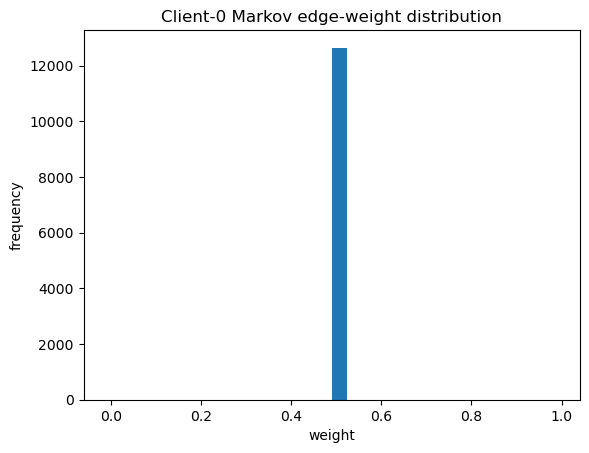

In [48]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Move your data
data_pg = data_pg

# Move edge_index and edge_weight for each Markov layer to the same device
markov_edges = [edge for edge in markov_edges]
markov_weights = [weight for weight in markov_weights]


model = MarkovGCN_LSTM(
    ndim=64,
    nlayers=len(markov_edges),  # or 3
    nclasses=len(torch.unique(data_pg.y)),
    in_dim=data_pg.x.size(1),
    edges=markov_edges,
    weights=markov_weights,lstm_hidden=HIDDEN)# -------------------------------------------------------------
# Quick sanity visual (client 0)
# -------------------------------------------------------------
plt.hist(client_graphs_markov[0].edge_weight.cpu().numpy(), bins=30)
plt.title("Client-0 Markov edge-weight distribution")
plt.xlabel("weight")
plt.ylabel("frequency")
plt.show()


optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)

 

In [30]:
from sklearn.metrics import accuracy_score, f1_score
import matplotlib.pyplot as plt
import torch.nn.functional as F
import torch
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001, weight_decay=5e-4)

# Store metrics
train_losses, val_losses = [], []
train_accs, val_accs = [], []dataframe_to_graph()
train_f1s, val_f1s = [], []

best_f1 = 0.0
best_model_path = "best_markov_lstm_model-edgeIIoT.pth"

for epoch in range(1000):
    model.train()
    optimizer.zero_grad()
    
    out = model(data_pg.x)

    # Compute loss
    loss = F.nll_loss(out[data_pg.train_mask], data_pg.y[data_pg.train_mask])
    loss.backward()
    optimizer.step()

    # Predictions
    with torch.no_grad():
        model.eval()
        pred_train = out[data_pg.train_mask].argmax(dim=1)
        pred_val = out[data_pg.test_mask].argmax(dim=1)

        y_train = data_pg.y[data_pg.train_mask]
        y_val = data_pg.y[data_pg.test_mask]

        train_acc = accuracy_score(y_train.cpu(), pred_train.cpu())
        val_acc = accuracy_score(y_val.cpu(), pred_val.cpu())

        train_f1 = f1_score(y_train.cpu(), pred_train.cpu(), average="macro")
        val_f1 = f1_score(y_val.cpu(), pred_val.cpu(), average="macro")

        train_losses.append(loss.item())
        val_loss = F.nll_loss(out[data_pg.test_mask], y_val).item()
        val_losses.append(val_loss)

        train_accs.append(train_acc)
        val_accs.append(val_acc)

        train_f1s.append(train_f1)
        val_f1s.append(val_f1)

        # Save best model
        if val_f1 > best_f1:
            best_f1 = val_f1
            torch.save(model.state_dict(), best_model_path)

    # Print every 50 epochs
    if epoch % 50 == 0:
        print(f"[Epoch {epoch}] "
              f"Train Loss: {loss.item():.4f} | Acc: {train_acc:.4f} | F1: {train_f1:.4f} || "
              f"Val Loss: {val_loss:.4f} | Acc: {val_acc:.4f} | F1: {val_f1:.4f}")

print(f"\n✅ Best model saved with Val Macro F1 Score: {best_f1:.4f} at: {best_model_path}")


[Epoch 0] Train Loss: 0.0585 | Acc: 0.9866 | F1: 0.9728 || Val Loss: 0.0677 | Acc: 0.9849 | F1: 0.9756
[Epoch 50] Train Loss: 0.0585 | Acc: 0.9866 | F1: 0.9728 || Val Loss: 0.0676 | Acc: 0.9847 | F1: 0.9737
[Epoch 100] Train Loss: 0.0584 | Acc: 0.9866 | F1: 0.9728 || Val Loss: 0.0676 | Acc: 0.9847 | F1: 0.9737
[Epoch 150] Train Loss: 0.0583 | Acc: 0.9866 | F1: 0.9728 || Val Loss: 0.0676 | Acc: 0.9847 | F1: 0.9737
[Epoch 200] Train Loss: 0.0583 | Acc: 0.9866 | F1: 0.9728 || Val Loss: 0.0675 | Acc: 0.9849 | F1: 0.9738
[Epoch 250] Train Loss: 0.0582 | Acc: 0.9866 | F1: 0.9728 || Val Loss: 0.0675 | Acc: 0.9847 | F1: 0.9737
[Epoch 300] Train Loss: 0.0581 | Acc: 0.9866 | F1: 0.9728 || Val Loss: 0.0674 | Acc: 0.9847 | F1: 0.9737
[Epoch 350] Train Loss: 0.0581 | Acc: 0.9866 | F1: 0.9728 || Val Loss: 0.0674 | Acc: 0.9847 | F1: 0.9737
[Epoch 400] Train Loss: 0.0580 | Acc: 0.9866 | F1: 0.9728 || Val Loss: 0.0673 | Acc: 0.9847 | F1: 0.9737
[Epoch 450] Train Loss: 0.0579 | Acc: 0.9866 | F1: 0.9728 

In [31]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

model.load_state_dict(torch.load("best_markov_lstm_model-edgeIIoT.pth", map_location="cuda"))
model.eval()
# Set the model to evaluation mode
model.eval()
with torch.no_grad():
    logits = model(data_pg.x)  # Output shape: [num_nodes, nclasses]
    preds = logits.argmax(dim=1)

# Extract test predictions and labels
test_pred = preds[data_pg.test_mask]
test_true = data_pg.y[data_pg.test_mask]

# Compute Accuracy
acc = accuracy_score(test_true.cpu().numpy(), test_pred.cpu().numpy())
print(f"\n🎯 Final Test Accuracy: {acc:.4f}")

# Confusion Matrix
conf_matrix = confusion_matrix(test_true.cpu().numpy(), test_pred.cpu().numpy())
print("\n📉 Confusion Matrix:")
print(conf_matrix)

# Classification Report
class_report = classification_report(test_true.cpu().numpy(), test_pred.cpu().numpy(), digits=4)
print("\n📋 Classification Report:")
print(class_report)



🎯 Final Test Accuracy: 0.9847

📉 Confusion Matrix:
[[ 449   15    0    4    0    0    0    0    0    0    0    0    0    0
     0]
 [  13  482    1    1    1    0    0    0    0    1    0    1    1    0
     1]
 [   0    0  780    1    0    4    0    0    1    0    0    0    0    0
     1]
 [   0    0    0  678    0    0    0    1    1    1    0    0    0    1
     0]
 [   0    0    0    0  745    0    0    0    0    0    0    0    0    1
     0]
 [   0    6    0    0    0   35    0    0    0    0    0    0    0    0
     0]
 [   0    0    0    1    1    0   18    0    0    0    0    0    0    0
     0]
 [   0    2    2    1    1    0    0 1141    2    1    0    0    1    2
     2]
 [   0    1    1    0    0    0    0    2  469    0    1    0    0    0
     1]
 [   0    0    0    1    3    0    0    0    0  415    0    0    0    0
     0]
 [   0    0    0    0    1    0    0    1    2    0  454    0    0    0
     2]
 [   0    1    0    0    0    0    0    0    0    0    1  484    0  

In [27]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

model.load_state_dict(torch.load("best_markov_lstm_model-edgeIIoT.pth", map_location="cuda"))
model.eval()
# Set the model to evaluation mode
model.eval()
with torch.no_grad():
    logits = model(data_pg.x)  # Output shape: [num_nodes, nclasses]
    preds = logits.argmax(dim=1)

# Extract test predictions and labels
test_pred = preds[data_pg.test_mask]
test_true = data_pg.y[data_pg.test_mask]

# Compute Accuracy
acc = accuracy_score(test_true.cpu().numpy(), test_pred.cpu().numpy())
print(f"\n🎯 Final Test Accuracy: {acc:.4f}")

# Confusion Matrix
conf_matrix = confusion_matrix(test_true.cpu().numpy(), test_pred.cpu().numpy())
print("\n📉 Confusion Matrix:")
print(conf_matrix)

# Classification Report
class_report = classification_report(test_true.cpu().numpy(), test_pred.cpu().numpy(), digits=4)
print("\n📋 Classification Report:")
print(class_report)



🎯 Final Test Accuracy: 0.9824

📉 Confusion Matrix:
[[ 443   16    0    5    2    0    0    0    0    0    1    1    0    0
     0]
 [  22  475    0    0    0    0    0    0    1    1    0    0    0    1
     2]
 [   0    0  776    0    0    4    0    0    0    1    0    0    0    1
     0]
 [   0    0    2  682    0    0    0    1    0    3    0    0    0    1
     0]
 [   0    0    2    0  743    0    0    0    1    0    2    0    0    0
     0]
 [   0    6    0    0    0   35    0    0    0    0    0    0    0    0
     1]
 [   0    0    0    1    1    0   18    0    0    0    0    0    0    0
     0]
 [   0    0    3    0    2    0    1 1141    0    0    0    0    0    0
     6]
 [   0    0    0    0    1    0    0    2  467    0    0    0    0    1
     4]
 [   0    0    2    0    3    0    0    1    0  413    0    0    1    0
     1]
 [   1    1    0    0    1    0    0    0    1    0  457    0    0    0
     0]
 [   0    0    0    0    0    0    0    0    0    2    0  480    0  

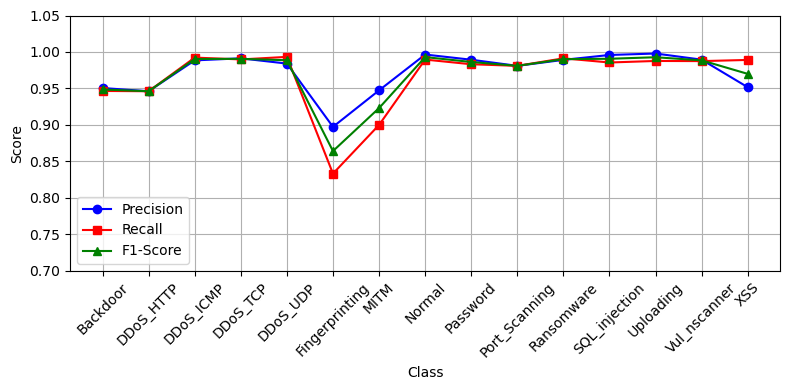

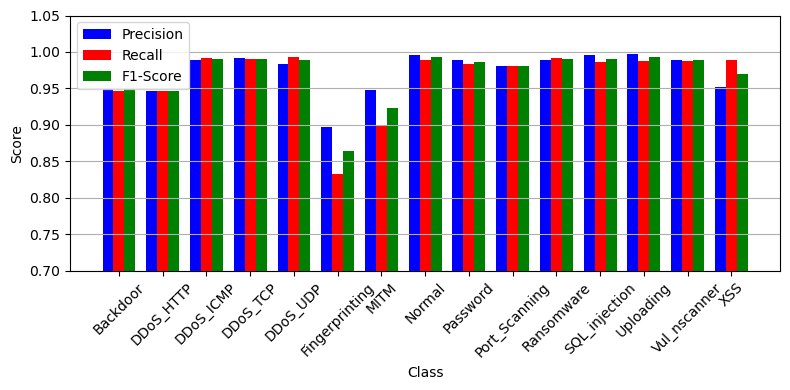

In [33]:
import matplotlib.pyplot as plt
import numpy as np

# Class labels
class_names = [
    'Backdoor', 'DDoS_HTTP', 'DDoS_ICMP', 'DDoS_TCP', 'DDoS_UDP',
    'Fingerprinting', 'MITM', 'Normal', 'Password', 'Port_Scanning',
    'Ransomware', 'SQL_injection', 'Uploading', 'Vul_nscanner', 'XSS'
]

# Classification metrics from your report
precision = [0.9506, 0.9462, 0.9885, 0.9913, 0.9841,
             0.8974, 0.9474, 0.9965, 0.9894, 0.9810,
             0.9892, 0.9959, 0.9979, 0.9895, 0.9517]

recall =    [0.9466, 0.9462, 0.9923, 0.9898, 0.9933,
             0.8333, 0.9000, 0.9896, 0.9832, 0.9810,
             0.9913, 0.9856, 0.9877, 0.9875, 0.9891]

f1_score =  [0.9486, 0.9462, 0.9904, 0.9906, 0.9887,
             0.8642, 0.9231, 0.9930, 0.9863, 0.9810,
             0.9902, 0.9907, 0.9928, 0.9885, 0.9700]

x = np.arange(len(class_names))

# 🎯 Line Plot
plt.figure(figsize=(8, 4))
plt.plot(x, precision, 'o-', label='Precision', color='blue')
plt.plot(x, recall, 's-', label='Recall', color='red')
plt.plot(x, f1_score, '^-', label='F1-Score', color='green')
plt.xticks(x, class_names, rotation=45)
plt.xlabel("Class")
plt.ylabel("Score")
plt.ylim(0.7, 1.05)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.savefig("Line Plot-edgeiot15.png", dpi=300, bbox_inches='tight')
plt.show()

# 📊 Bar Chart
bar_width = 0.25
plt.figure(figsize=(8, 4))
plt.bar(x - bar_width, precision, width=bar_width, label='Precision', color='blue')
plt.bar(x, recall, width=bar_width, label='Recall', color='red')
plt.bar(x + bar_width, f1_score, width=bar_width, label='F1-Score', color='green')
plt.xticks(x, class_names, rotation=45)
plt.xlabel("Class")
plt.ylabel("Score")
plt.ylim(0.7, 1.05)
plt.grid(True, axis='y')
plt.legend()
plt.tight_layout()
plt.savefig("Bar Chart-edgeiot15.png", dpi=300, bbox_inches='tight')
plt.show()


## FL 

In [18]:
import pandas as pd
from collections import defaultdict
import numpy as np

def stratified_clients(df: pd.DataFrame,
                       label_col: str = "Attack_type",
                       n_clients: int = 5,
                       shuffle: bool = True,
                       random_state: int = 123):
    """
    Returns a list  [df_client0, …, df_clientN-1]  where every client
    receives ~⌊class_count / n_clients⌋ rows from *each* Attack_type.
    Any leftover rows (because class_count % n_clients ≠ 0) are
    distributed round-robin.
    """
    rng = np.random.default_rng(random_state)
    clients = [list() for _ in range(n_clients)]

    # 1 – group indices by label
    label_groups = df.groupby(label_col).indices

    for label, idxs in label_groups.items():
        idxs = list(idxs)
        if shuffle:
            rng.shuffle(idxs)

        # 2 – chunk into n_clients almost-equal slices
        chunks = np.array_split(idxs, n_clients)

        # 3 – assign to clients
        for c_id, chunk in enumerate(chunks):
            clients[c_id].extend(chunk)

    # 4 – build DataFrames, preserving original column order
    client_dfs = [df.loc[sorted(idxs)].reset_index(drop=True) for idxs in clients]
    return client_dfs


In [19]:
cleaned_df = data

clients_balanced = stratified_clients(cleaned_df, label_col="Attack_type", n_clients=5)
# Quick sanity-check
for i, cdf in enumerate(clients_balanced):
    print(f"\nClient {i} class counts:")
    print(cdf["Attack_type"].value_counts())



Client 0 class counts:
Attack_type
7     966
4     580
2     564
1     420
11    412
3     410
12    409
13    403
8     399
0     395
10    388
14    383
9     358
5     172
6      73
Name: count, dtype: int64

Client 1 class counts:
Attack_type
7     965
4     580
2     564
1     420
11    412
3     410
12    409
13    403
8     399
0     395
10    388
14    383
9     357
5     172
6      73
Name: count, dtype: int64

Client 2 class counts:
Attack_type
7     965
4     580
2     564
1     420
11    411
3     410
12    409
13    403
8     399
0     395
10    388
14    382
9     357
5     171
6      73
Name: count, dtype: int64

Client 3 class counts:
Attack_type
7     965
4     580
2     563
1     420
11    411
3     410
12    409
13    402
8     399
0     395
10    387
14    382
9     357
5     171
6      73
Name: count, dtype: int64

Client 4 class counts:
Attack_type
7     965
4     580
2     563
1     419
11    411
3     409
12    408
13    402
8     399
0     394
10    387
14    

In [20]:
# -------------------------------------------------------------
# 0. Hyper-params you may want to tweak once
# -------------------------------------------------------------
N_CLIENTS = 5
EDGE_TEST_PCT = 0.20     # edges kept for test – used only for node-feature aggregation
NODE_TEST_PCT = 0.30     # node train/test masks
RAND_SEED     = 123
INFLATE, NLAYERS, EPS = 1.5, 3, 0.01

# -------------------------------------------------------------
# 1.  Re-use our earlier scaler + h-vector helper
# -------------------------------------------------------------
from sklearn.preprocessing import StandardScaler
import numpy as np, pandas as pd

def add_scaled_h(df, drop_cols=("ip_src_host","ip_dst_host","Attack_type")):
    df = df.copy()
    numeric_cols  = df.select_dtypes(include=[np.number]).columns
    cols_to_norm  = list(set(numeric_cols) - set(drop_cols))
    scaler = StandardScaler()
    df[cols_to_norm] = scaler.fit_transform(df[cols_to_norm])
    df["h"] = df[cols_to_norm].values.tolist()
    return df

clients_proc = [add_scaled_h(cdf) for cdf in clients_balanced]

# -------------------------------------------------------------
# 2.  Helper → DataFrame  ➔  PyG Data  (safe splits)
# -------------------------------------------------------------
import torch, networkx as nx
from torch_geometric.data import Data
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from collections import defaultdict

def dataframe_to_graph(df,
                       src="ip_src_host", dst="ip_dst_host",
                       label="Attack_type", h="h",
                       edge_test_pct=EDGE_TEST_PCT,
                       node_test_pct=NODE_TEST_PCT,
                       seed=RAND_SEED):
    # ---- 80/20 edge split (stratified) ------------------------------------
    # ---- 80/20 edge split (stratified) ------------------------------------
    X_tr, _ = train_test_split(
        df,                       # ← ONLY the DataFrame
        test_size=edge_test_pct,
        random_state=seed,
        stratify=df[label]        # ← stratify argument is fine
    )


    # ---- build directed MultiGraph ---------------------------------------
    g_nx = nx.from_pandas_edgelist(
        X_tr, src, dst, [h, label], create_using=nx.MultiGraph()
    ).to_directed()

    node_map = {n:i for i,n in enumerate(g_nx.nodes())}
    g_nx = nx.relabel_nodes(g_nx, node_map)

    # ---- edge_index & placeholder weights --------------------------------
    e_idx  = torch.tensor([(u,v) for u,v,_ in g_nx.edges(data=True)],
                          dtype=torch.long).t().contiguous()
    e_attr = torch.ones((e_idx.size(1),1), dtype=torch.float)    # overwritten later

    # ---- node features (mean of incident edge h-vectors) ------------------
    feat_dim = len(X_tr.iloc[0][h])
    node_feats = defaultdict(list)
    for u,v,attr in g_nx.edges(data=True):
        node_feats[u].append(attr[h])
        node_feats[v].append(attr[h])
    num_nodes = len(g_nx.nodes())
    x = torch.zeros((num_nodes,feat_dim))
    for n,vecs in node_feats.items():
        x[n] = torch.tensor(vecs).mean(0)

    # ---- node labels ------------------------------------------------------
    le = LabelEncoder().fit(df[label])
    node_lab_map = {}
    for _,row in X_tr.iterrows():
        for n in (row[src],row[dst]):
            node_lab_map.setdefault(n, le.transform([row[label]])[0])
    y = torch.tensor([node_lab_map.get(orig,0) for orig in node_map.keys()])

    # ---- node masks (random split, fallback if stratification fails) ------
    nodes = list(node_map.keys())
    labs  = [node_lab_map.get(n,0) for n in nodes]
    try:
        tr_nodes, te_nodes = train_test_split(
            nodes, test_size=node_test_pct, random_state=seed, stratify=labs)
    except ValueError:
        tr_nodes, te_nodes = train_test_split(
            nodes, test_size=node_test_pct, random_state=seed, stratify=None)

    train_mask = torch.zeros(num_nodes,dtype=torch.bool)
    test_mask  = torch.zeros(num_nodes,dtype=torch.bool)
    for n in tr_nodes: train_mask[node_map[n]] = True
    for n in te_nodes: test_mask[node_map[n]] = True

    return Data(x=x, edge_index=e_idx, edge_attr=e_attr,
                y=y, train_mask=train_mask, test_mask=test_mask)



In [21]:
from tqdm import tqdm
client_graphs = []
for cdf in tqdm(clients_proc, desc="Building graphs"):
    g = dataframe_to_graph(cdf)          # ← now receives a DataFrame
    g = markov_process_agg_sparse(
            g, eps=EPS, inflate=INFLATE, nlayers=NLAYERS,
            row_normalization=True, debug=False
        )
    client_graphs.append(g)

print(client_graphs[0])


Building graphs:   0%|                                    | 0/5 [00:00<?, ?it/s]/home/safa/anaconda3/lib/python3.11/site-packages/torch_sparse/matmul.py:97: UserWarning: Sparse CSR tensor support is in beta state. If you miss a functionality in the sparse tensor support, please submit a feature request to https://github.com/pytorch/pytorch/issues. (Triggered internally at ../aten/src/ATen/SparseCsrTensorImpl.cpp:53.)
  C = torch.sparse.mm(A, B)
Building graphs: 100%|████████████████████████████| 5/5 [00:04<00:00,  1.20it/s]

([tensor([[   0,    1,    1,  ..., 5317, 5318, 5319],
        [   1,    0,    5,  ...,    3,   25,    3]]), tensor([[   1,    3,    8,  ..., 5252, 5310, 5311],
        [   1,    3,    8,  ..., 5252, 5310, 5311]]), tensor([[   1,    3,    8,  ..., 5252, 5310, 5311],
        [   1,    3,    8,  ..., 5252, 5310, 5311]])], [tensor([[0.4900],
        [0.4900],
        [0.4900],
        ...,
        [0.4900],
        [0.4900],
        [0.4900]]), tensor([0.9997, 0.9998, 0.9999, 0.9993, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0

In [22]:
client_graphs = []
for cdf in tqdm(clients_proc, desc="Building graphs"):
    g = dataframe_to_graph(cdf)                      # g is a proper Data object

    # run Markov routine but *do not* overwrite g
    ei_layers, ew_layers = markov_process_agg_sparse(
        g, eps=EPS, inflate=INFLATE, nlayers=NLAYERS,
        row_normalization=True, debug=False
    )

    # pick the last layer (= most sparsified) as edge_index / edge_attr
    g.edge_index = ei_layers[-1]
    ew_final     = ew_layers[-1]
    # ensure edge_attr has shape [E, 1]
    g.edge_attr  = ew_final.unsqueeze(1) if ew_final.dim() == 1 else ew_final

    client_graphs.append(g)

print(client_graphs[0])


Building graphs: 100%|████████████████████████████| 5/5 [00:04<00:00,  1.19it/s]

Data(x=[5320, 46], edge_index=[2, 540], edge_attr=[540, 1], y=[5320], train_mask=[5320], test_mask=[5320])


In [23]:
client_graphs

[Data(x=[5320, 46], edge_index=[2, 540], edge_attr=[540, 1], y=[5320], train_mask=[5320], test_mask=[5320]),
 Data(x=[5314, 46], edge_index=[2, 530], edge_attr=[530, 1], y=[5314], train_mask=[5314], test_mask=[5314]),
 Data(x=[5293, 46], edge_index=[2, 485], edge_attr=[485, 1], y=[5293], train_mask=[5293], test_mask=[5293]),
 Data(x=[5323, 46], edge_index=[2, 555], edge_attr=[555, 1], y=[5323], train_mask=[5323], test_mask=[5323]),
 Data(x=[5302, 46], edge_index=[2, 507], edge_attr=[507, 1], y=[5302], train_mask=[5302], test_mask=[5302])]

In [24]:
g = client_graphs[0]          # pick any client 0-4
w = g.edge_attr.squeeze()     # shape [E]  (E = number of edges)

print("Num edges   :", w.numel())
print("min / max   :", float(w.min()), float(w.max()))
print("mean        :", float(w.mean()))
print("non-zero %  :", (w != 0).sum().item() / w.numel() * 100)
print("unique vals :", torch.unique(w)[:10], " ...")  # first 10 uniques


Num edges   : 540
min / max   : 0.16139835119247437 1.0
mean        : 0.9870371222496033
non-zero %  : 100.0
unique vals : tensor([0.1614, 0.3333, 0.8386, 1.0000, 1.0000])  ...


In [36]:
# -------------------------------------------------------------
# helper : DataFrame  ➔  PyG Data      (no-Markov version)
# -------------------------------------------------------------
import torch, networkx as nx
from torch_geometric.data import Data
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from collections import defaultdict

def dataframe_to_graph_nomarkov(df,
                                src="ip_src_host",
                                dst="ip_dst_host",
                                label="Attack_type",
                                h="h",
                                node_test_pct=0.30,
                                random_state=42):
    """Return a PyG Data graph whose
       • edge_attr = h-vector ⨁ [attack_label]
       • x         = mean(h) per node
       • y         = per-node attack label (int)
       • train_mask / test_mask on nodes
    """
    # 1. encode Attack_type → int  (needed for edges & y)
    le = LabelEncoder().fit(df[label])
    df["_y_"] = le.transform(df[label])          # keep original col intact
    # 2. build directed MultiGraph with edge attrs
    g_nx = nx.from_pandas_edgelist(
        df, src, dst, [h, "_y_"], create_using=nx.MultiGraph()
    ).to_directed()

    # 3. relabel nodes 0…N-1
    node_map = {n: i for i, n in enumerate(g_nx.nodes())}
    g_nx = nx.relabel_nodes(g_nx, node_map)

    # 4. edge_index  &  edge_attr  (h ⨁ attack_label)
    e_idx, e_attr = [], []
    for u, v, attr in g_nx.edges(data=True):
        e_idx.append((u, v))
        e_attr.append(attr[h] + [attr["_y_"]])

    edge_index = torch.tensor(e_idx, dtype=torch.long).t().contiguous()
    edge_attr  = torch.tensor(e_attr, dtype=torch.float)

    # 5. node features  = mean of incident h-vectors
    feat_dim = len(df.iloc[0][h])
    node_feats = defaultdict(list)
    for u, v, attr in g_nx.edges(data=True):
        node_feats[u].append(attr[h])
        node_feats[v].append(attr[h])

    num_nodes = len(g_nx.nodes())
    x = torch.zeros((num_nodes, feat_dim), dtype=torch.float)
    for n, vecs in node_feats.items():
        x[n] = torch.tensor(vecs).mean(0)

    # 6. per-node labels (first label seen)
    node_label_map = {}
    for _, row in df.iterrows():
        for n in (row[src], row[dst]):
            node_label_map.setdefault(n, le.transform([row[label]])[0])
    y = torch.tensor([node_label_map.get(orig, 0) for orig in node_map.keys()])

    # 7. train/test node masks (stratified 70/30, fallback if tiny class)
    nodes = list(node_map.keys())
    labs  = [node_label_map.get(n, 0) for n in nodes]
    try:
        tr_nodes, te_nodes = train_test_split(
            nodes, test_size=node_test_pct, random_state=random_state,
            stratify=labs
        )
    except ValueError:
        tr_nodes, te_nodes = train_test_split(
            nodes, test_size=node_test_pct, random_state=random_state,
            stratify=None
        )

    train_mask = torch.zeros(num_nodes, dtype=torch.bool)
    test_mask  = torch.zeros(num_nodes, dtype=torch.bool)
    for n in tr_nodes: train_mask[node_map[n]] = True
    for n in te_nodes: test_mask[node_map[n]]  = True

    return Data(x=x, edge_index=edge_index, edge_attr=edge_attr,
                y=y, train_mask=train_mask, test_mask=test_mask)


# -------------------------------------------------------------
# build graphs for the 5 balanced client tables
# -------------------------------------------------------------
client_graphs_nomarkov = [
    dataframe_to_graph_nomarkov(cdf) for cdf in clients_proc   # ← clients_proc
]

for i, g in enumerate(client_graphs_nomarkov):
    print(f"Client {i}: {g}")


Client 0: Data(x=[6651, 46], edge_index=[2, 12664], edge_attr=[12664, 47], y=[6651], train_mask=[6651], test_mask=[6651])
Client 1: Data(x=[6643, 46], edge_index=[2, 12660], edge_attr=[12660, 47], y=[6643], train_mask=[6643], test_mask=[6643])
Client 2: Data(x=[6618, 46], edge_index=[2, 12654], edge_attr=[12654, 47], y=[6618], train_mask=[6618], test_mask=[6618])
Client 3: Data(x=[6645, 46], edge_index=[2, 12648], edge_attr=[12648, 47], y=[6645], train_mask=[6645], test_mask=[6645])
Client 4: Data(x=[6619, 46], edge_index=[2, 12638], edge_attr=[12638, 47], y=[6619], train_mask=[6619], test_mask=[6619])


In [26]:
# -------------------------------------------------------------
# Hyper-parameters for the Markov routine
# -------------------------------------------------------------
EPS      = 0.01     # pruning threshold
INFLATE  = 1.5
NLAYERS  = 1        # depth of expand–inflate cycles

# -------------------------------------------------------------
# Apply Markov sparse weighting to every client graph
# -------------------------------------------------------------
import matplotlib.pyplot as plt

client_graphs_markov = []          # keep a fresh list
for i, g in enumerate(client_graphs_nomarkov):
    # markov_process_agg_sparse RETURNS: ([layer0_ei, …], [layer0_w, …])
    ei_layers, ew_layers = markov_process_agg_sparse(
        g, eps=EPS, inflate=INFLATE, nlayers=NLAYERS,
        row_normalization=True, debug=False
    )

    # pick the LAST layer (= most sparsified)
    g.edge_index  = ei_layers[-1]
    w_final       = ew_layers[-1]
    g.edge_weight = w_final.float()          # PyG expects 1-D tensor here

    # If you still want the old edge_attr (h-vector ⨁ label) keep it;
    # otherwise drop to save GPU memory:
    # g.edge_attr = None

    client_graphs_markov.append(g)

    print(f"✓ Client {i} | nodes {g.num_nodes:4d} | edges {g.edge_weight.numel():5d}")




✓ Client 0 | nodes 6651 | edges 12648
✓ Client 1 | nodes 6643 | edges 12646
✓ Client 2 | nodes 6618 | edges 12642
✓ Client 3 | nodes 6645 | edges 12634
✓ Client 4 | nodes 6619 | edges 12636


In [27]:
# -------------------------------------------------------------
# Markov parameters
# -------------------------------------------------------------
EPS      = 0.01
INFLATE  = 1.5

# -------------------------------------------------------------
# Containers
# -------------------------------------------------------------
client_graphs_markov   = []   # graphs with final-layer edges for FL training
client_layer_edges     = []   # list[client] → list[layer] → edge_index
client_layer_weights   = []   # list[client] → list[layer] → weight vector

# -------------------------------------------------------------
# Run Markov per client
# -------------------------------------------------------------
for cid, g in enumerate(client_graphs_nomarkov):

    # ----  make a lightweight copy with 1-D initial weights  ----
    g_for_m = g.clone()
    g_for_m.edge_attr = torch.ones(g_for_m.edge_index.size(1))  # shape [E]

    # ----  full Markov stack  ----
    ei_layers, ew_layers = markov_process_agg_sparse(
        g_for_m,
        eps=EPS, inflate=INFLATE, nlayers=NLAYERS,
        row_normalization=True, debug=False
    )
    print(len(ew_layers[0]))


    # store every layer for later inspection
    client_layer_edges.append(ei_layers)
    client_layer_weights.append(ew_layers)

    # write the LAST layer back into the train-time graph
    g.edge_index  = ei_layers[-1]
    g.edge_weight = ew_layers[-1].float()      # 1-D tensor

    client_graphs_markov.append(g)

    print(f"✓ Client {cid} | layer edge counts "
          f"{[w.numel() for w in ew_layers]}")


12648
✓ Client 0 | layer edge counts [12648]
12646
✓ Client 1 | layer edge counts [12646]
12642
✓ Client 2 | layer edge counts [12642]
12634
✓ Client 3 | layer edge counts [12634]
12636
✓ Client 4 | layer edge counts [12636]


In [54]:
import numpy as np 
 
from sklearn.metrics import accuracy_score, f1_score

def local_train1(model, client_data, epochs=5, lr=0.01, eps=0.01, inflate=1.5, nlayers=3):
    model.train()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    # Recompute Markov edges and weights for this client
    edges, weights = markov_process_agg_sparse(client_data, eps=eps, inflate=inflate, nlayers=nlayers)
    model.edges = edges
    model.weights = weights

    for epoch in range(epochs):
        optimizer.zero_grad()
        out = model(client_data.x)
        loss = F.nll_loss(out[client_data.train_mask], client_data.y[client_data.train_mask])
        loss.backward()
        optimizer.step()

    # Evaluation
    model.eval()
    with torch.no_grad():
        out = model(client_data.x)
        pred = out.argmax(dim=1)
        y_true = client_data.y

        acc = accuracy_score(y_true[client_data.train_mask].cpu(), pred[client_data.train_mask].cpu())
        f1 = f1_score(y_true[client_data.train_mask].cpu(), pred[client_data.train_mask].cpu(), average="macro")

    return copy.deepcopy(model.state_dict()), acc, f1

def local_train(model, client_data, epochs=5, lr=0.01, eps=0.01, inflate=1.5, nlayers=3, client_id=None):
    model.train()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    # Recompute Markov edges and weights for this client
    edges, weights = markov_process_agg_sparse(client_data, eps=eps, inflate=inflate, nlayers=nlayers)
    model.edges = edges
    model.weights = weights

    for epoch in range(epochs):
        optimizer.zero_grad()
        out = model(client_data.x)
        loss = F.nll_loss(out[client_data.train_mask], client_data.y[client_data.train_mask])
        loss.backward()
        optimizer.step()

        if epoch % 100 == 0 or epoch == epochs - 1:
            prefix = f"[Client {client_id}] " if client_id is not None else ""
            print(f"{prefix}Epoch {epoch+1}/{epochs} | Loss: {loss.item():.4f}")

    # Evaluation
    model.eval()
    with torch.no_grad():
        out = model(client_data.x)
        pred = out.argmax(dim=1)
        y_true = client_data.y

        acc = accuracy_score(y_true[client_data.train_mask].cpu(), pred[client_data.train_mask].cpu())
        f1 = f1_score(y_true[client_data.train_mask].cpu(), pred[client_data.train_mask].cpu(), average="macro")

    print(f"📊 Final Evaluation for Client {client_id}: Accuracy = {acc:.4f}, F1 Score = {f1:.4f}")

    return copy.deepcopy(model.state_dict()), acc, f1


def local_train_bb(model, client_data, edges, weights, epochs=5, lr=0.01, client_id=None):
    print(len(weights[0]))
    model.train()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    model.edges = edges
    model.weights = weights

    best_f1 = 0
    best_state = None

    for epoch in range(epochs):
        optimizer.zero_grad()
        out = model(client_data.x)
        loss = F.nll_loss(out[client_data.train_mask], client_data.y[client_data.train_mask])
        loss.backward()
        optimizer.step()

        # Evaluate on training data
        model.eval()
        with torch.no_grad():
            out = model(client_data.x)
            pred = out.argmax(dim=1)
            y_true = client_data.y

            acc = accuracy_score(y_true[client_data.train_mask].cpu(), pred[client_data.train_mask].cpu())
            f1 = f1_score(y_true[client_data.train_mask].cpu(), pred[client_data.train_mask].cpu(), average="macro")

        if f1 > best_f1:
            best_f1 = f1
            best_state = copy.deepcopy(model.state_dict())

        if epoch % 100 == 0 or epoch == epochs - 1:
            prefix = f"[Client {client_id}] " if client_id is not None else ""
            print(f"{prefix}Epoch {epoch+1}/{epochs} | Loss: {loss.item():.4f} | Acc: {acc:.4f} | F1: {f1:.4f}")

        model.train()

    print(f"📊 Best Training Evaluation for Client {client_id}: F1 Score = {best_f1:.4f}")

    return best_state, acc, best_f1

from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

def local_train_b(
    model, client_data, edges, weights, epochs=3000, lr=0.01,
    client_id=None, patience=200, step_size=300, gamma=0.9):

    model.train()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=gamma)

    model.edges = edges
    model.weights = weights

    best_f1 = 0
    best_state = None
    best_test_acc = 0
    best_test_f1 = 0
    no_improve_counter = 0

    for epoch in range(epochs):
        optimizer.zero_grad()
        out = model(client_data.x)
        loss = F.nll_loss(out[client_data.train_mask], client_data.y[client_data.train_mask])
        loss.backward()
        optimizer.step()
        scheduler.step()

        model.eval()
        with torch.no_grad():
            out = model(client_data.x)
            pred = out.argmax(dim=1)
            y_true = client_data.y

            train_acc = accuracy_score(y_true[client_data.train_mask].cpu(), pred[client_data.train_mask].cpu())
            train_f1 = f1_score(y_true[client_data.train_mask].cpu(), pred[client_data.train_mask].cpu(), average="macro")

            test_acc = accuracy_score(y_true[client_data.test_mask].cpu(), pred[client_data.test_mask].cpu())
            test_f1 = f1_score(y_true[client_data.test_mask].cpu(), pred[client_data.test_mask].cpu(), average="macro")

        if test_f1 > best_f1:
            best_f1 = test_f1
            best_state = copy.deepcopy(model.state_dict())
            best_test_acc = test_acc
            best_test_f1 = test_f1
            no_improve_counter = 0
        else:
            no_improve_counter += 1

        if epoch % 100 == 0 or epoch == epochs - 1:
            prefix = f"[Client {client_id}] " if client_id is not None else ""
            print(f"{prefix}Epoch {epoch+1}/{epochs} | "
                  f"Train Loss: {loss.item():.4f} | Train Acc: {train_acc:.4f} | Train F1: {train_f1:.4f} || "
                  f"Test Acc: {test_acc:.4f} | Test F1: {test_f1:.4f}")

        if no_improve_counter >= patience:
            print(f"⏹️ Early stopping triggered at epoch {epoch+1} for Client {client_id}")
            break

        model.train()

    print(f"\n📊 Best Test Evaluation for Client {client_id}: Accuracy = {best_test_acc:.4f}, F1 Score = {best_test_f1:.4f}")

    # Final test evaluation (best model)
    model.load_state_dict(best_state)
    model.eval()
    with torch.no_grad():
        out = model(client_data.x)
        pred = out.argmax(dim=1)
        y_true = client_data.y

        test_preds = pred[client_data.test_mask].cpu().numpy()
        test_labels = y_true[client_data.test_mask].cpu().numpy()

        print(f"\n🧪 Final Test Report for Client {client_id}:")
        print(classification_report(test_labels, test_preds, digits=4))

        cm = confusion_matrix(test_labels, test_preds)
        print(cm)
    return best_state, best_test_acc, best_test_f1



def federated_avg(weight_list):
    avg_weights = copy.deepcopy(weight_list[0])
    for key in avg_weights.keys():
        for i in range(1, len(weight_list)):
            avg_weights[key] += weight_list[i][key]
        avg_weights[key] = avg_weights[key] / len(weight_list)
    return avg_weights


def plot_federated_metrics(accs, f1s, prefix="fed_gnn"):
    rounds = range(1, len(accs) + 1)

    # Accuracy
    plt.figure(figsize=(5, 3))
    plt.plot(rounds, accs, marker='o', label='Global Accuracy')
    plt.title('Federated Accuracy per Round')
    plt.xlabel('Round')
    plt.ylabel('Accuracy')
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.savefig(f"{prefix}_acc_curve.png")
    plt.show()

    # F1 Score
    plt.figure(figsize=(5, 3))
    plt.plot(rounds, f1s, marker='s', color='green', label='Global F1 Score')
    plt.title('Federated F1 Score per Round')
    plt.xlabel('Round')
    plt.ylabel('Macro F1 Score')
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.savefig(f"{prefix}_f1_curve.png")
    plt.show()


In [29]:
import copy
from torch.nn.functional import nll_loss


🌀  --- FedAvg round 1/10 ---
2930
[Client 0] Epoch 1/5000 | Loss: 2.7105 | Acc: 0.0641 | F1: 0.0331
[Client 0] Epoch 101/5000 | Loss: 1.3590 | Acc: 0.5478 | F1: 0.3956
[Client 0] Epoch 201/5000 | Loss: 1.0842 | Acc: 0.5924 | F1: 0.4666
[Client 0] Epoch 301/5000 | Loss: 0.9537 | Acc: 0.6565 | F1: 0.5641
[Client 0] Epoch 401/5000 | Loss: 0.8480 | Acc: 0.6825 | F1: 0.6137
[Client 0] Epoch 501/5000 | Loss: 0.7715 | Acc: 0.7019 | F1: 0.6408
[Client 0] Epoch 601/5000 | Loss: 0.7112 | Acc: 0.7261 | F1: 0.6705
[Client 0] Epoch 701/5000 | Loss: 0.6569 | Acc: 0.7539 | F1: 0.7060
[Client 0] Epoch 801/5000 | Loss: 0.6038 | Acc: 0.7818 | F1: 0.7443
[Client 0] Epoch 901/5000 | Loss: 0.5520 | Acc: 0.8143 | F1: 0.7874
[Client 0] Epoch 1001/5000 | Loss: 0.5039 | Acc: 0.8357 | F1: 0.8141
[Client 0] Epoch 1101/5000 | Loss: 0.4611 | Acc: 0.8449 | F1: 0.8255
[Client 0] Epoch 1201/5000 | Loss: 0.4239 | Acc: 0.8570 | F1: 0.8414
[Client 0] Epoch 1301/5000 | Loss: 0.3911 | Acc: 0.8691 | F1: 0.8555
[Client 0] 

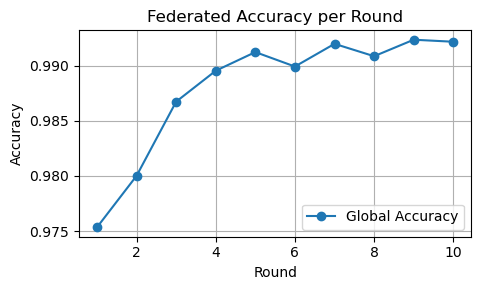

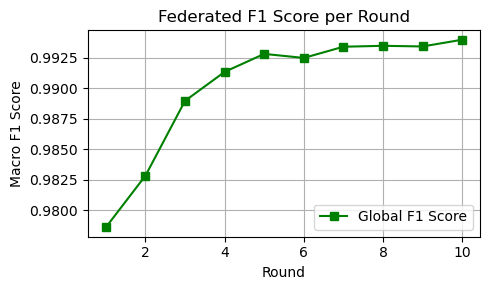

In [35]:
# -------------------------------------------------------------
# FEDERATED CONFIG
# -------------------------------------------------------------
N_ROUNDS      = 10           # communication rounds
LOCAL_EPOCHS  = 5000            # epochs per client per round
LR            = 1e-3
SEED          = 42

torch.manual_seed(SEED)

# -------------------------------------------------------------
# 1)  Initialise a *global* MarkovGCN-LSTM
# -------------------------------------------------------------
IN_DIM   = client_graphs_markov[0].x.size(1)    # 46
HIDDEN    = 64
NDIM      = 64
N_CLASSES = int(client_graphs_markov[0].y.max().item() + 1)

# dummy edges/weights (over-written inside local_train)
dummy_edges   = [client_layer_edges[0][0]] * NLAYERS
dummy_weights = [client_layer_weights[0][0]] * NLAYERS

global_model = MarkovGCN_LSTM(
    ndim=NDIM, nlayers=NLAYERS, nclasses=N_CLASSES,
    in_dim=IN_DIM, edges=dummy_edges, weights=dummy_weights,
    lstm_hidden=HIDDEN
)
global_state = global_model.state_dict()              # reference weights

# -------------------------------------------------------------
# 2)  Containers for round-wise metrics
# -------------------------------------------------------------
round_accs, round_f1s = [], []

# -------------------------------------------------------------
# 3)  FEDERATED TRAINING LOOP
# -------------------------------------------------------------
for rnd in range(1, N_ROUNDS + 1):
    print(f"\n🌀  --- FedAvg round {rnd}/{N_ROUNDS} ---")

    client_states, client_accs, client_f1s = [], [], []

    # --- LOCAL UPDATES ----------------------------------------------------
    for cid in range(len(client_graphs_markov)):
        g      = client_graphs_markov[cid]
        edges  = client_layer_edges[cid]
        weights= client_layer_weights[cid]

        # build client model with GLOBAL weights + its own Markov stack
        client_model = MarkovGCN_LSTM(
            ndim=NDIM, nlayers=NLAYERS, nclasses=N_CLASSES,
            in_dim=IN_DIM, edges=edges, weights=weights,
            lstm_hidden=HIDDEN
        )
        client_model.load_state_dict(global_state, strict=False)

        # run local training (you can swap to local_train_b / local_train_bb etc.)
        updated_state, acc, f1 = local_train_bb(
            client_model, g, edges, weights,
            epochs=LOCAL_EPOCHS, lr=LR, client_id=cid
        )

        client_states.append(updated_state)
        client_accs.append(acc)
        client_f1s.append(f1)

    # --- FEDERATED AVERAGING ---------------------------------------------
    global_state = federated_avg(client_states)

    # push new weights back into the global model object (optional)
    global_model.load_state_dict(global_state, strict=False)

    # --- TRACK METRICS ----------------------------------------------------
    round_accs.append(np.mean(client_accs))
    round_f1s .append(np.mean(client_f1s))

    print(f"✅  Round {rnd} | mean-train-Acc = {round_accs[-1]:.4f} | "
          f"mean-train-F1 = {round_f1s[-1]:.4f}")

# -------------------------------------------------------------
# 4)  VISUALISE FEDERATED PROGRESS
# -------------------------------------------------------------
plot_federated_metrics(round_accs, round_f1s, prefix="markov_gcn_lstm_fed")



🌀  --- FedAvg round 1/10 ---
2930
[Client 0] Epoch 1/1000 | Loss: 2.7105 | Acc: 0.0641 | F1: 0.0331
[Client 0] Epoch 101/1000 | Loss: 1.3590 | Acc: 0.5478 | F1: 0.3956
[Client 0] Epoch 201/1000 | Loss: 1.0842 | Acc: 0.5924 | F1: 0.4666
[Client 0] Epoch 301/1000 | Loss: 0.9537 | Acc: 0.6565 | F1: 0.5641
[Client 0] Epoch 401/1000 | Loss: 0.8480 | Acc: 0.6825 | F1: 0.6137
[Client 0] Epoch 501/1000 | Loss: 0.7715 | Acc: 0.7019 | F1: 0.6408
[Client 0] Epoch 601/1000 | Loss: 0.7112 | Acc: 0.7261 | F1: 0.6705
[Client 0] Epoch 701/1000 | Loss: 0.6569 | Acc: 0.7539 | F1: 0.7060
[Client 0] Epoch 801/1000 | Loss: 0.6038 | Acc: 0.7818 | F1: 0.7443
[Client 0] Epoch 901/1000 | Loss: 0.5520 | Acc: 0.8143 | F1: 0.7874
[Client 0] Epoch 1000/1000 | Loss: 0.5044 | Acc: 0.8357 | F1: 0.8144
📊 Best Training Evaluation for Client 0: F1 Score = 0.8144
2932
[Client 1] Epoch 1/1000 | Loss: 2.7105 | Acc: 0.0667 | F1: 0.0440
[Client 1] Epoch 101/1000 | Loss: 1.3171 | Acc: 0.5385 | F1: 0.3928
[Client 1] Epoch 201

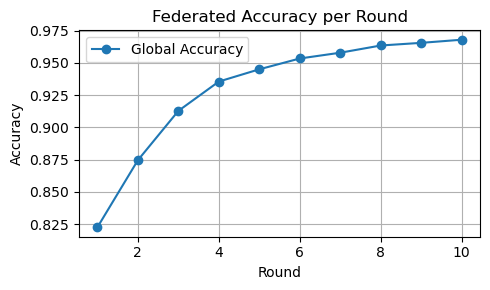

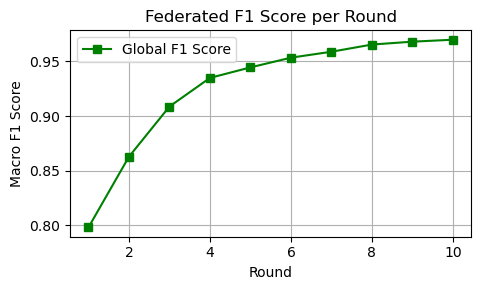

In [36]:
# -------------------------------------------------------------
# FEDERATED CONFIG
# -------------------------------------------------------------
N_ROUNDS      = 10           # communication rounds
LOCAL_EPOCHS  = 1000            # epochs per client per round
LR            = 1e-3
SEED          = 42

torch.manual_seed(SEED)

# -------------------------------------------------------------
# 1)  Initialise a *global* MarkovGCN-LSTM
# -------------------------------------------------------------
IN_DIM   = client_graphs_markov[0].x.size(1)    # 46
HIDDEN    = 64
NDIM      = 64
N_CLASSES = int(client_graphs_markov[0].y.max().item() + 1)

# dummy edges/weights (over-written inside local_train)
dummy_edges   = [client_layer_edges[0][0]] * NLAYERS
dummy_weights = [client_layer_weights[0][0]] * NLAYERS

global_model = MarkovGCN_LSTM(
    ndim=NDIM, nlayers=NLAYERS, nclasses=N_CLASSES,
    in_dim=IN_DIM, edges=dummy_edges, weights=dummy_weights,
    lstm_hidden=HIDDEN
)
global_state = global_model.state_dict()              # reference weights

# -------------------------------------------------------------
# 2)  Containers for round-wise metrics
# -------------------------------------------------------------
round_accs, round_f1s = [], []

# -------------------------------------------------------------
# 3)  FEDERATED TRAINING LOOP
# -------------------------------------------------------------
for rnd in range(1, N_ROUNDS + 1):
    print(f"\n🌀  --- FedAvg round {rnd}/{N_ROUNDS} ---")

    client_states, client_accs, client_f1s = [], [], []

    # --- LOCAL UPDATES ----------------------------------------------------
    for cid in range(len(client_graphs_markov)):
        g      = client_graphs_markov[cid]
        edges  = client_layer_edges[cid]
        weights= client_layer_weights[cid]

        # build client model with GLOBAL weights + its own Markov stack
        client_model = MarkovGCN_LSTM(
            ndim=NDIM, nlayers=NLAYERS, nclasses=N_CLASSES,
            in_dim=IN_DIM, edges=edges, weights=weights,
            lstm_hidden=HIDDEN
        )
        client_model.load_state_dict(global_state, strict=False)

        # run local training (you can swap to local_train_b / local_train_bb etc.)
        updated_state, acc, f1 = local_train_bb(
            client_model, g, edges, weights,
            epochs=LOCAL_EPOCHS, lr=LR, client_id=cid
        )

        client_states.append(updated_state)
        client_accs.append(acc)
        client_f1s.append(f1)

    # --- FEDERATED AVERAGING ---------------------------------------------
    global_state = federated_avg(client_states)

    # push new weights back into the global model object (optional)
    global_model.load_state_dict(global_state, strict=False)

    # --- TRACK METRICS ----------------------------------------------------
    round_accs.append(np.mean(client_accs))
    round_f1s .append(np.mean(client_f1s))

    print(f"✅  Round {rnd} | mean-train-Acc = {round_accs[-1]:.4f} | "
          f"mean-train-F1 = {round_f1s[-1]:.4f}")

# -------------------------------------------------------------
# 4)  VISUALISE FEDERATED PROGRESS
# -------------------------------------------------------------
plot_federated_metrics(round_accs, round_f1s, prefix="markov_gcn_lstm_fed")


In [ ]:
# -------------------------------------------------------------
# FEDERATED CONFIG
# -------------------------------------------------------------
N_ROUNDS      = 30           # communication rounds
LOCAL_EPOCHS  = 1500            # epochs per client per round
LR            = 1e-3
SEED          = 42

torch.manual_seed(SEED)

# -------------------------------------------------------------
# 1)  Initialise a *global* MarkovGCN-LSTM
# -------------------------------------------------------------
IN_DIM   = client_graphs_markov[0].x.size(1)    # 46
HIDDEN    = 64
NDIM      = 64
N_CLASSES = int(client_graphs_markov[0].y.max().item() + 1)

# dummy edges/weights (over-written inside local_train)
dummy_edges   = [client_layer_edges[0][0]] * NLAYERS
dummy_weights = [client_layer_weights[0][0]] * NLAYERS

global_model = MarkovGCN_LSTM(
    ndim=NDIM, nlayers=NLAYERS, nclasses=N_CLASSES,
    in_dim=IN_DIM, edges=dummy_edges, weights=dummy_weights,
    lstm_hidden=HIDDEN
)
global_state = global_model.state_dict()              # reference weights

# -------------------------------------------------------------
# 2)  Containers for round-wise metrics
# -------------------------------------------------------------
round_accs, round_f1s = [], []

# -------------------------------------------------------------
# 3)  FEDERATED TRAINING LOOP
# -------------------------------------------------------------
for rnd in range(1, N_ROUNDS + 1):
    print(f"\n🌀  --- FedAvg round {rnd}/{N_ROUNDS} ---")

    client_states, client_accs, client_f1s = [], [], []

    # --- LOCAL UPDATES ----------------------------------------------------
    for cid in range(len(client_graphs_markov)):
        g      = client_graphs_markov[cid]
        edges  = client_layer_edges[cid]
        weights= client_layer_weights[cid]

        # build client model with GLOBAL weights + its own Markov stack
        client_model = MarkovGCN_LSTM(
            ndim=NDIM, nlayers=NLAYERS, nclasses=N_CLASSES,
            in_dim=IN_DIM, edges=edges, weights=weights,
            lstm_hidden=HIDDEN
        )
        client_model.load_state_dict(global_state, strict=False)

        # run local training (you can swap to local_train_b / local_train_bb etc.)
        updated_state, acc, f1 = local_train_bb(
            client_model, g, edges, weights,
            epochs=LOCAL_EPOCHS, lr=LR, client_id=cid
        )

        client_states.append(updated_state)
        client_accs.append(acc)
        client_f1s.append(f1)

    # --- FEDERATED AVERAGING ---------------------------------------------
    global_state = federated_avg(client_states)

    # push new weights back into the global model object (optional)
    global_model.load_state_dict(global_state, strict=False)

    # --- TRACK METRICS ----------------------------------------------------
    round_accs.append(np.mean(client_accs))
    round_f1s .append(np.mean(client_f1s))

    print(f"✅  Round {rnd} | mean-train-Acc = {round_accs[-1]:.4f} | "
          f"mean-train-F1 = {round_f1s[-1]:.4f}")

# -------------------------------------------------------------
# 4)  VISUALISE FEDERATED PROGRESS
# -------------------------------------------------------------
plot_federated_metrics(round_accs, round_f1s, prefix="markov_gcn_lstm_fed")



🌀  --- FedAvg round 1/30 ---
12648
[Client 0] Epoch 1/1500 | Loss: 2.7167 | Acc: 0.0853 | F1: 0.0605
[Client 0] Epoch 101/1500 | Loss: 1.4199 | Acc: 0.5012 | F1: 0.3507
[Client 0] Epoch 201/1500 | Loss: 1.1702 | Acc: 0.5590 | F1: 0.4827
[Client 0] Epoch 301/1500 | Loss: 1.0583 | Acc: 0.6219 | F1: 0.5648
[Client 0] Epoch 401/1500 | Loss: 0.9656 | Acc: 0.6395 | F1: 0.5799
[Client 0] Epoch 501/1500 | Loss: 0.8886 | Acc: 0.6576 | F1: 0.6002
[Client 0] Epoch 601/1500 | Loss: 0.8323 | Acc: 0.6756 | F1: 0.6246
[Client 0] Epoch 701/1500 | Loss: 0.7924 | Acc: 0.7173 | F1: 0.6828
[Client 0] Epoch 801/1500 | Loss: 0.7544 | Acc: 0.7411 | F1: 0.7082
[Client 0] Epoch 901/1500 | Loss: 0.7179 | Acc: 0.7540 | F1: 0.7230
[Client 0] Epoch 1001/1500 | Loss: 0.6861 | Acc: 0.7652 | F1: 0.7346
[Client 0] Epoch 1101/1500 | Loss: 0.6592 | Acc: 0.7712 | F1: 0.7426
[Client 0] Epoch 1201/1500 | Loss: 0.6369 | Acc: 0.7768 | F1: 0.7486
[Client 0] Epoch 1301/1500 | Loss: 0.6185 | Acc: 0.7800 | F1: 0.7524
[Client 0]

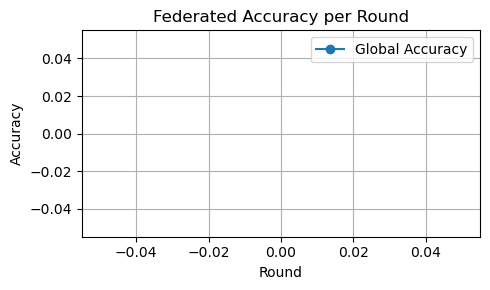

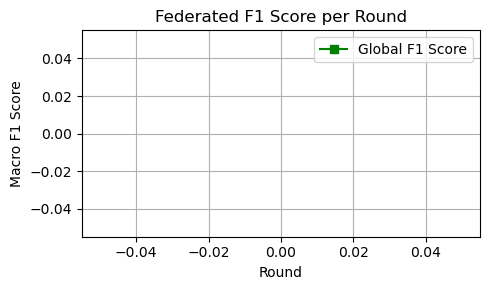

In [55]:
# -------------------------------------------------------------
# 4)  VISUALISE FEDERATED PROGRESS
# -------------------------------------------------------------
plot_federated_metrics(round_accs, round_f1s, prefix="markov_gcn_lstm_fed")
